In [2]:
import numpy as np
import pandas as pd

from collections import defaultdict
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error, r2_score

from src.minimum_variance_delta import MinimumVarianceDelta, MinMax
from src.black_scholes import CallPut

import matplotlib.pyplot as plt

In [3]:
# Lets first do the analysis over a single delta bucket and see how the model performs - Call option ATM
start_date = dt(2023, 1, 1)
end_date = dt(2023, 12, 31)

# Days to expiry buckets
# 15  -  45 days => 1 Month
# 65  - 105 days => 3 Months
# 165 - 195 days => 6 Months
# 240 - 300 days => 9 Months
# 335 - 395 days => 12 Months
term_structure = {
    '1M': MinMax(30, 45),
    '3M': MinMax(45, 125),
    '6M': MinMax(125, 225),
    '9M': MinMax(225, 325),
    '12M': MinMax(325, 395),
}

# Call Delta buckets
call_delta_structure = {
    '30': MinMax(0.25, 0.35),
    '40': MinMax(0.35, 0.45),
    '50': MinMax(0.45, 0.55),
}


In [8]:
# Lets first do the analysis over a single delta bucket and see how the model performs 
#   - Call option OTM (35 - 45 delta)
#   - 15 day rolling estimation
#   - 45 - 125 days to expiry

mvd = MinimumVarianceDelta(
    min_delta=0.35, 
    max_delta=0.45, 
    min_dte=45, 
    max_dte=125, 
    call_put=CallPut.CALL, 
    start_date=start_date, 
    end_date=end_date
)
coef = mvd.fit(rolling_window_size=15, fit_intercept=False)
df = mvd.results_df(coefficients=coef)

<AxesSubplot:xlabel='QUOTE_DATE'>

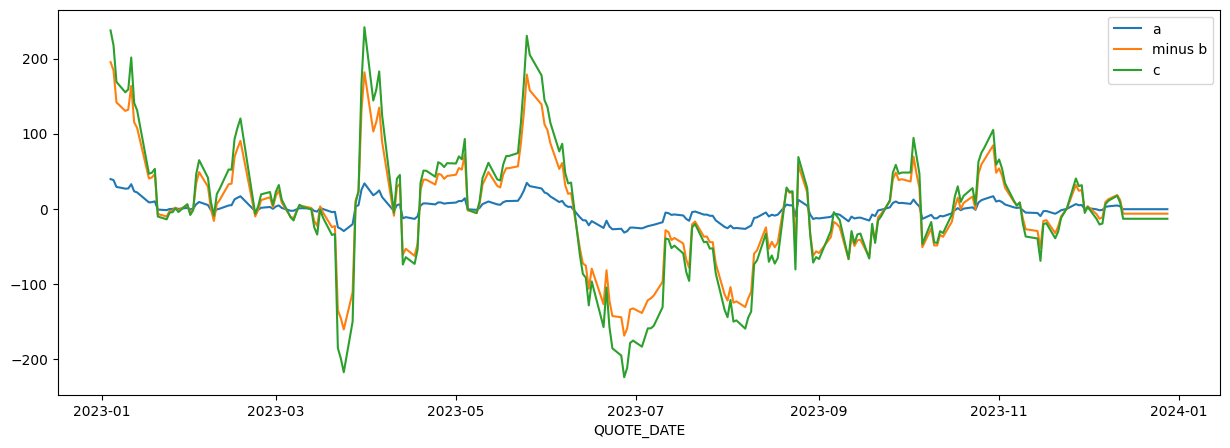

In [9]:
# Plot the parameters a, b and c through time
df['minus b'] = df['b'] * -1
df[['QUOTE_DATE', 'a', 'minus b', 'c']].plot(x='QUOTE_DATE', figsize=(15, 5))


In [7]:
# Run the model over all expiries and OTM call delta buckets we've specified
results = defaultdict(lambda: defaultdict(dict))
for ts, (min_dte, max_dte) in term_structure.items():
    for bucket, (min_delta, max_delta) in call_delta_structure.items():
        mvd = MinimumVarianceDelta(
            min_delta=min_delta, 
            max_delta=max_delta, 
            min_dte=min_dte, 
            max_dte=max_dte, 
            call_put=CallPut.CALL, 
            start_date=start_date, 
            end_date=end_date
        )
        coef = mvd.fit(rolling_window_size=None, fit_intercept=False)
        df = mvd.results_df(coefficients=coef)
        results[ts][bucket] = df


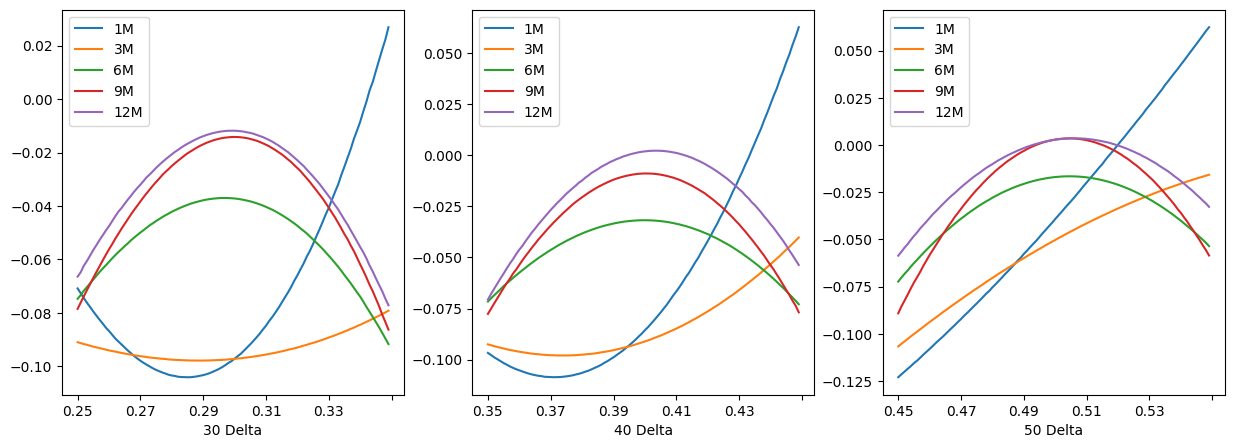

In [8]:
# Plot Minimum Variance Delta - Black Scholes Delta for each term structure and delta bucket
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, delta in enumerate(call_delta_structure.keys()):
    for ts, df in results.items():
        df = df[delta]
        df['delta_bin'] = pd.cut(df['DELTA'], bins=100)
        df = df.groupby('delta_bin').agg({'MVD-BS': 'mean'})
        df = df.rename(columns={'MVD-BS': ts})
        df.index = df.index.map(lambda x: x.left)
        df.index.name = f'{delta} Delta'
        df.plot(ax=ax[i], label=ts)
plt.legend()
plt.show()

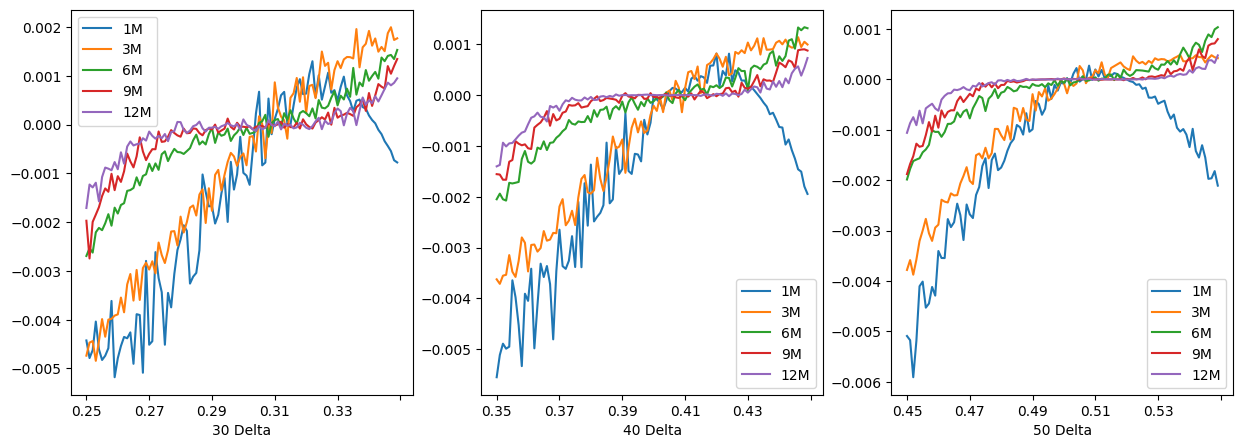

In [9]:
# Plot expected change in implied volatility for each term structure and delta bucket
ig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, delta in enumerate(call_delta_structure.keys()):
    for ts, df in results.items():
        df = df[delta]
        df['delta_bin'] = pd.cut(df['DELTA'], bins=100)
        df = df.groupby('delta_bin').agg({'EIV': 'mean'})
        df = df.rename(columns={'EIV': ts})
        df.index = df.index.map(lambda x: x.left)
        df.index.name = f'{delta} Delta'
        df.plot(ax=ax[i], label=ts)
plt.legend()
plt.show()

In [10]:
# Calculate some basic statistics
#   - Gain
#   - R2
#   - RMSE
def get_results_table(metric_fn, results):
    df = pd.DataFrame(data={
        expiry: [metric_fn(results[expiry][delta]) for delta in call_delta_structure.keys()]
        for expiry in results.keys()
    }, index=pd.Index([delta for delta in call_delta_structure.keys()], name='Delta'))
    return df


def gain_fn(df):
    return 1 - np.sum(np.square(df['ERROR_MV'])) / np.sum(np.square(df['ERROR_BS']))


def r2(df):
    return r2_score(df['Y'], df['Y_HAT'])


def rmse(df):
    return np.sqrt(mean_squared_error(df['Y'], df['Y_HAT']))


_gain = get_results_table(gain_fn, results)
_r2 = get_results_table(r2, results)
_rmse = get_results_table(rmse, results)

In [11]:
_gain

,1M,3M,6M,9M,12M
Delta,,,,,
30,0.184847,0.215854,0.138938,0.105570,0.084537
40,0.133541,0.116048,0.072650,0.053972,0.037624
50,0.089673,0.057190,0.038689,0.038485,0.018393


In [12]:
_r2

,1M,3M,6M,9M,12M
Delta,,,,,
30,-0.368928,0.024823,0.010441,0.008419,0.008005
40,-0.508034,-0.110616,-0.073908,-0.042631,-0.034851
50,-0.590180,-0.169281,-0.108148,-0.053147,-0.049855


In [13]:
_rmse

,1M,3M,6M,9M,12M
Delta,,,,,
30,3.572640,4.995222,4.118307,3.951429,3.760027
40,4.290762,6.193176,5.061402,4.859238,4.438479
50,4.698340,6.921195,5.460338,5.352129,4.932983
